In [1]:
# Cell 1: Install necessary libraries
!pip install transformers accelerate bitsandbytes sentencepiece datasets evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
# Cell 2: Import required libraries
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import numpy as np
from datasets import Dataset
import re
from tqdm.notebook import tqdm

In [3]:
# Cell 3: Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1e9} GB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(0) / 1e9} GB")


CUDA available: True
Current GPU: Tesla T4
Memory allocated: 0.0 GB
Memory reserved: 0.0 GB


In [ ]:
# Cell 4: Load model and tokenizer with optimizations for T4 GPU
model_id = "meta-llama/Llama-3.1-8B-Instruct"

# Set up authentication for Hugging Face
import os
from huggingface_hub import login

# You'll need to enter your Hugging Face token here
hf_token = "your token"  # Replace with your actual token
login(token=hf_token)

# Load model with 4-bit quantization to fit on T4 GPU
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    load_in_4bit=True,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [24]:
# Cell 5: Create sample Hinglish data (you can replace with your own dataset)
sample_data = [
    {"text": "Yeh to kaafi goodlooking hai!", "label": "positive"},
    {"text": "Food ka taste theek tha but service was very slow.", "label": "neutral"},
    {"text": "Mujhe yeh product bilkul pasand nahi aaya, total waste of money.", "label": "negative"},
    {"text": "College ka first day thoda boring tha lekin baad mein maza aaya.", "label": "neutral"},
    {"text": "Kal ka match ekdum fantastic tha, india ne kya performance diya!", "label": "positive"},
    {"text": "Train late ho gayi aur AC bhi kaam nahi kar raha tha. Worst journey ever.", "label": "negative"},
    {"text": "Naya phone kaafi impressive hai but battery life could be better.", "label": "neutral"},
    {"text": "Office mein aaj meeting bahut productive rahi, boss ne appreciate kiya.", "label": "positive"}
]

df = pd.DataFrame(sample_data)
dataset = Dataset.from_pandas(df)

In [25]:
# Cell 6: Define sentiment analysis function using Llama-3.1
def analyze_sentiment(text):
    prompt = f"""<|begin_of_text|><|system|>
You are an expert in analyzing sentiment in code-mixed Hinglish (Hindi-English) text.
Classify the following text as positive, negative, or neutral.
Only respond with one word: positive, negative, or neutral.

<|user|>
Text: {text}

<|assistant|>
"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            temperature=0.1,
            top_p=0.95,
            do_sample=True
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the sentiment from the response
    sentiment = response.split("<|assistant|>")[-1].strip().lower()

    # Normalize the output
    if "positive" in sentiment:
        return "positive"
    elif "negative" in sentiment:
        return "negative"
    else:
        return "neutral"

In [26]:
# Cell 7: Test the sentiment analysis on sample data
results = []

for i, example in enumerate(tqdm(sample_data)):
    text = example["text"]
    true_label = example["label"]
    predicted = analyze_sentiment(text)
    results.append({
        "text": text,
        "true_label": true_label,
        "predicted": predicted,
        "correct": true_label == predicted
    })

results_df = pd.DataFrame(results)

  0%|          | 0/8 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [27]:
# Cell 8: Calculate and display accuracy
accuracy = results_df["correct"].mean() * 100
print(f"Accuracy: {accuracy:.2f}%")

# Display results table
results_df

Accuracy: 75.00%


,text,true_label,predicted,correct
0,Yeh to kaafi goodlooking hai!,positive,positive,True
1,Food ka taste theek tha but service was very s...,neutral,neutral,True
2,"Mujhe yeh product bilkul pasand nahi aaya, tot...",negative,negative,True
3,College ka first day thoda boring tha lekin ba...,neutral,positive,False
4,"Kal ka match ekdum fantastic tha, india ne kya...",positive,positive,True
5,Train late ho gayi aur AC bhi kaam nahi kar ra...,negative,negative,True
6,Naya phone kaafi impressive hai but battery li...,neutral,positive,False
7,"Office mein aaj meeting bahut productive rahi,...",positive,positive,True


from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('true_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('predicted').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('correct').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['true_label'].value_counts()
    for x_label, grp in results_df.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('true_label')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['predicted'].value_counts()
    for x_label, grp in results_df.groupby('true_label')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('true_label')
_ = plt.ylabel('predicted')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['correct'].value_counts()
    for x_label, grp in results_df.groupby('predicted')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('predicted')
_ = plt.ylabel('correct')

In [28]:
# Cell 9: Function to analyze custom input
def analyze_custom_input():
    while True:
        text = input("Enter Hinglish text (or 'q' to quit): ")
        if text.lower() == 'q':
            break
        sentiment = analyze_sentiment(text)
        print(f"Sentiment: {sentiment}")

# Run this function when you want to analyze custom inputs
# analyze_custom_input()

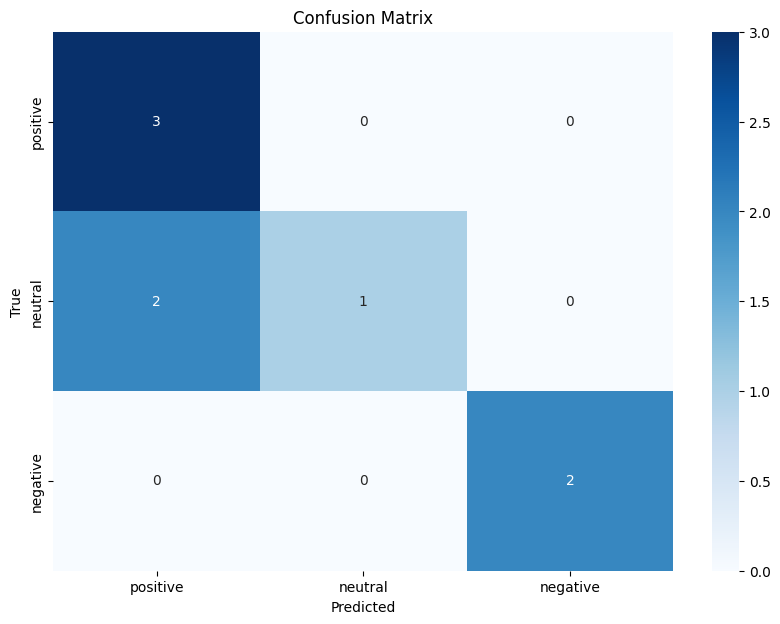

In [29]:
# Cell 10: Create a simple confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Only run this if you have multiple samples for each class
if len(results_df) > 5:
    cm = confusion_matrix(results_df["true_label"], results_df["predicted"], labels=["positive", "neutral", "negative"])
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [30]:
# Cell 11: Function to analyze a batch of texts (useful for larger datasets)
def batch_analyze_sentiment(texts, batch_size=4):
    results = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_results = [analyze_sentiment(text) for text in batch]
        results.extend(batch_results)

    return results

# Example usage for batch processing
# sample_texts = [example["text"] for example in sample_data]
# batch_results = batch_analyze_sentiment(sample_texts)